In [2]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import math


In [16]:
fontSize=16
#matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'font.family':'MathJax_SansSerif', 'font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'pdf.fonttype':42,'font.family':'DejaVu Sans','font.sans-serif':'Helvetica','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
plotStyles={"markersize":8,"markeredgewidth":1.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
barStyles={"width":0.65, "linewidth":0, "align":"center"}

/Users/turtle/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [298]:
ktx1_RM = 0.205; alpha_RM = 5; 
ktx1_RE = 1.04; ktr1 = 0.887; 
ktx2 = 2.54; ktr2 = 0.919; 
ktx3 = 5.29; ktr3 = 1.10; 
klamb = 0.131; 
kd = 0.025;  #0.25
km1 = 0.1; kP1 = 3.22e-9; 
km2 = 0.158; kP2 = 1.33e-9;
km3 = 0.1; kP3 = 0.369; 

n_a_RM_cI = 2; n_r_RM_cI = 6;
n_RM_cro = 3; n_RE = 5; 
n_cro_cI = 2.55; n_cro_cro = 2.22; 
n_cII_cI = 3.95; n_cII_cro = 3;
n_lamb_cI = 6; n_lamb_cro = 6;
n_cII = 1; 

K_a_RM_cI = 108; K_r_RM_cI = 528; K_RM_cro = 20.4; 
K_RE = 78.1; 
K_cro_cI = 64.1; K_cro_cro = 94.2;
K_cII_cI = 64.1; K_cII_cro = 94.2; 
K_lamb_cI = 241; K_lamb_cro = 500;
K_cII = 241; 

tau_lamb = 7.5; 


In [299]:
def f_cI_RE(cII):
    return (np.power(cII/K_RE,n_RE))/(1+np.power(cII/K_RE,n_RE))

def f_cI_RM(cI,cro):
    numer = 1 + alpha_RM*np.power(cI/K_a_RM_cI, n_a_RM_cI);
    denom = 1+np.power(cI/K_a_RM_cI,n_a_RM_cI)+np.power(cI/K_r_RM_cI,n_r_RM_cI)+np.power(cro/K_RM_cro,n_RM_cro)
    return numer/denom

def f_cro(cI,cro):
    return 1/(1+np.power(cI/K_cro_cI,n_cro_cI)+np.power(cro/K_cro_cro,n_cro_cro))

def f_cII(cI,cro):
    return 1/(1+np.power(cI/K_cII_cI,n_cII_cI)+np.power(cro/K_cII_cro,n_cII_cro))

def d_cII(cII):
    return 1/(1+np.power(cII/K_cII,n_cII))

def r_lamb(cI,cro,t):
    if t < tau_lamb:
        return 0
    else:
        return 1/(1+np.power(cI/K_lamb_cI,n_lamb_cI)+np.power(cro/K_lamb_cro,n_lamb_cro))
    

In [300]:
def myfunc0(y, t):
    mcI, mcro, mcII, cI, cro, cII, lamb = y
    dmcI = lamb*(ktx1_RM*f_cI_RM(cI,cro)+ktx1_RE*f_cI_RE(cII))-km1*mcI-kd*mcI;
    dmcro = lamb*ktx2*f_cro(cI,cro)-km2*mcro-kd*mcro;
    dmcII = lamb*ktx3*f_cII(cI,cro)-km3*mcII-kd*mcII;
    dcI = ktr1*mcI - kP1*cI - kd*cI;
    dcro = ktr2*mcro - kP2*cro - kd*cro;
    dcII = ktr3*mcII - kP3*d_cII(cII)*cII - kd*cII; 
#    dlamb = lamb*klamb*r_lamb(cI, cro,t)-kd*lamb;
    dlamb = -kd*lamb;
    dydt = [dmcI, dmcro, dmcII, dcI, dcro, dcII, dlamb]
    return dydt

def myfunc1(y, t):
    mcI, mcro, mcII, cI, cro, cII, lamb = y
    dmcI = lamb*(ktx1_RM*f_cI_RM(cI,cro)+ktx1_RE*f_cI_RE(cII))-km1*mcI-kd*mcI;
    dmcro = lamb*ktx2*f_cro(cI,cro)-km2*mcro-kd*mcro;
    dmcII = lamb*ktx3*f_cII(cI,cro)-km3*mcII-kd*mcII;
    dcI = ktr1*mcI - kP1*cI - kd*cI;
    dcro = ktr2*mcro - kP2*cro - kd*cro;
    dcII = ktr3*mcII - kP3*d_cII(cII)*cII - kd*cII; 
    dlamb = lamb*klamb*r_lamb(cI, cro,t)-kd*lamb;
    dydt = [dmcI, dmcro, dmcII, dcI, dcro, dcII, dlamb]
    return dydt

Text(0, 0.5, 'p_RM activity ([cro]=0)')

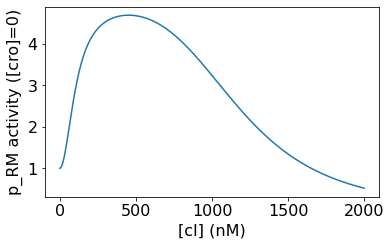

In [301]:
out = np.zeros(2000);
for cI in np.arange(0,2000,1):
    out[cI] = f_cI_RM(cI,0);
plt.rcParams["figure.figsize"] = (6,3.5)
plt.plot(np.arange(0,2000,1), out)
plt.xlabel('[cI] (nM)')
#plt.xscale('log')
plt.ylabel('p_RM activity ([cro]=0)')

Text(0, 0.5, 'p_RE activity')

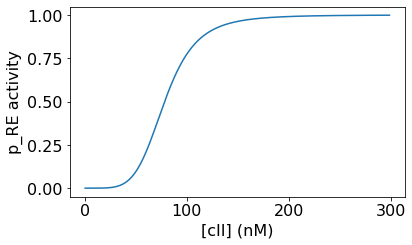

In [302]:
out = np.zeros(300);
for cII in np.arange(0,300,1):
    out[cII] = f_cI_RE(cII);
plt.rcParams["figure.figsize"] = (6,3.5)
plt.plot(np.arange(0,300,1), out)
plt.xlabel('[cII] (nM)')
plt.ylabel('p_RE activity')

Text(0, 0.5, 'cro transcription ([cI]=0)')

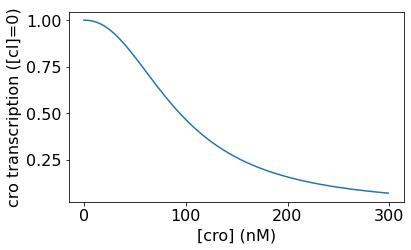

In [303]:
out = np.zeros(300);
for cro in np.arange(0,300,1):
    out[cro] = f_cro(0,cro);
plt.rcParams["figure.figsize"] = (6,3.5)
plt.plot(np.arange(0,300,1), out)
plt.xlabel('[cro] (nM)')
plt.ylabel('cro transcription ([cI]=0)')

Text(0, 0.5, 'cII transcription ([cI]=0)')

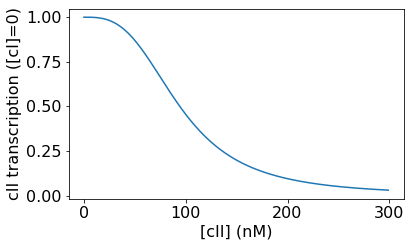

In [304]:
out = np.zeros(300);
for cII in np.arange(0,300,1):
    out[cII] = f_cII(0,cII);
plt.rcParams["figure.figsize"] = (6,3.5)
plt.plot(np.arange(0,300,1), out)
plt.xlabel('[cII] (nM)')
plt.ylabel('cII transcription ([cI]=0)')

## P- phages

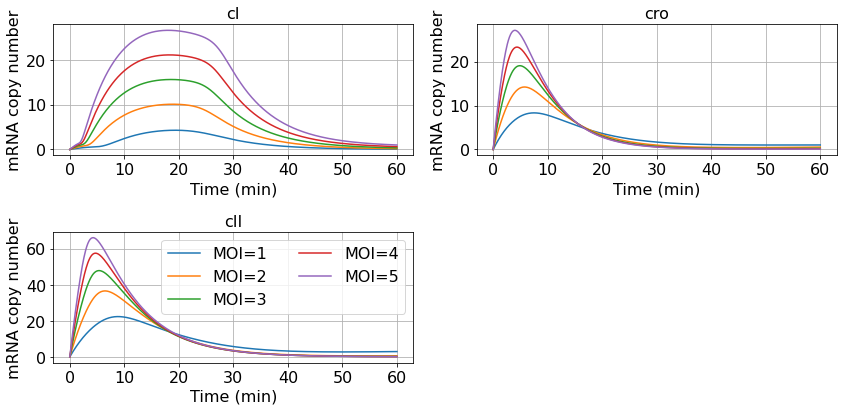

In [344]:
V = 1e-15; 
C = 1/6.02e23/V*1e9; 
t = np.linspace(0, 60, 601);
klamb = 0.131; 
kd = 0.025;  #0.25
labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (12,6)
for j in range(0,3):
    subplot(2,2,j+1);
    for moi in np.arange(1,6,1):
        lamb0 = moi*C;
        y0 = [0,0,0,0,0,0,lamb0];
        sol0 = odeint(myfunc0, y0, t);
        plt.plot(t,sol0[:,j]/C,label='MOI='+str(moi))
    if j == 2:
        plt.legend(ncol=2)
    plt.xlabel('Time (min)')
    plt.ylabel('mRNA copy number')
    plt.title(labels[j])
    plt.grid()
plt.tight_layout()

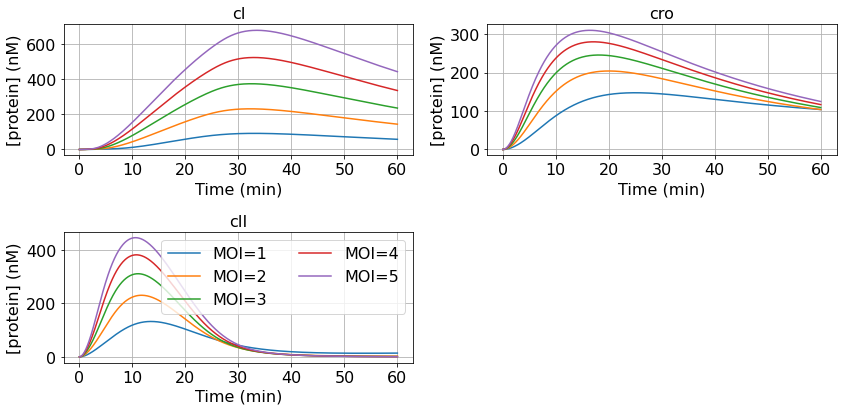

In [345]:
V = 1e-15; 
C = 1/6.02e23/V*1e9; 
t = np.linspace(0, 60, 601);
klamb = 0.131; 
kd = 0.025;  #0.25
labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (12,6)
for j in range(0,3):
    subplot(2,2,j+1);
    for moi in np.arange(1,6,1):
        lamb0 = moi*C;
        y0 = [0,0,0,0,0,0,lamb0];
        sol0 = odeint(myfunc0, y0, t);
        plt.plot(t,sol0[:,j+3],label='MOI='+str(moi))
    if j == 2:
        plt.legend(ncol=2)
    plt.xlabel('Time (min)')
    plt.ylabel('[protein] (nM)')
    plt.title(labels[j])
    plt.grid()
plt.tight_layout()

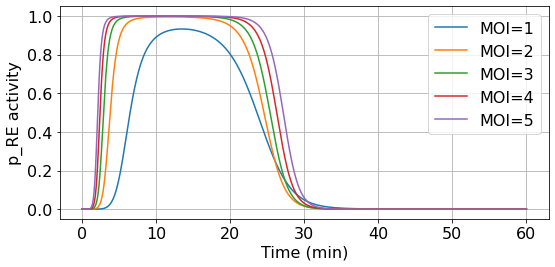

In [360]:
V = 1e-15; 
C = 1/6.02e23/V*1e9; 
t = np.linspace(0, 60, 601);
klamb = 0.131; 
kd = 0.025;  #0.25
labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (8,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc0, y0, t);
    cII = sol0[:,5];
    pRE = f_cI_RE(cII); 
    plt.plot(t,pRE,label='MOI='+str(moi))
plt.xlabel('Time (min)')
plt.ylabel('p_RE activity')
plt.legend()
plt.grid()
plt.tight_layout()

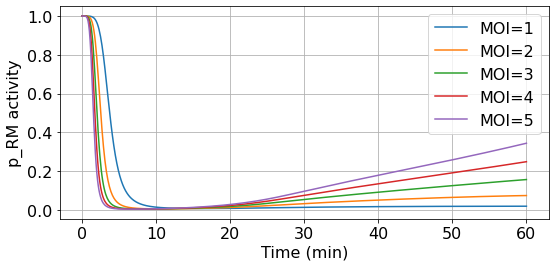

In [361]:
V = 1e-15; 
C = 1/6.02e23/V*1e9; 
t = np.linspace(0, 60, 601);
klamb = 0.131; 
kd = 0.025;  #0.25
labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (8,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc0, y0, t);
    cI = sol0[:,3];
    cro = sol0[:,4];
    pRM = f_cI_RM(cI,cro); 
    plt.plot(t,pRM,label='MOI='+str(moi))
plt.xlabel('Time (min)')
plt.ylabel('p_RM activity')
plt.legend()
plt.grid()
plt.tight_layout()

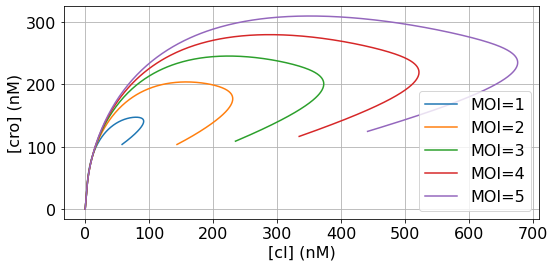

In [364]:
V = 1e-15; 
C = 1/6.02e23/V*1e9; 
t = np.linspace(0, 60, 601);
klamb = 0.131; 
kd = 0.025;  #0.25
labels = ['cI', 'cro', 'cII']
plt.rcParams["figure.figsize"] = (8,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc0, y0, t);
    cI = sol0[:,3];
    cro = sol0[:,4];
    plt.plot(cI,cro,label='MOI='+str(moi))
plt.xlabel('[cI] (nM)')
plt.ylabel('[cro] (nM)')
plt.legend()
plt.grid()
plt.tight_layout()

## P+ phages

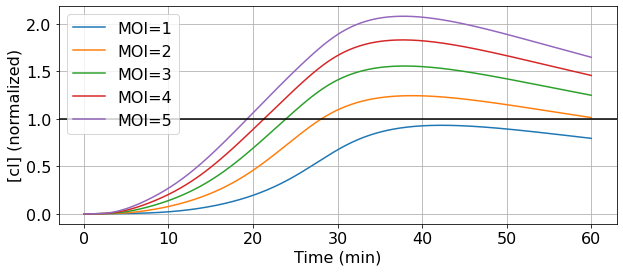

In [318]:
klamb = 0.131;
kd = 1/50; 
plt.rcParams["figure.figsize"] = (10,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    plt.plot(t,sol0[:,3]/610,label='MOI='+str(moi))
    plt.legend(ncol=1)
plt.axhline(1,color='black')
plt.xlabel('Time (min)')
plt.ylabel('[cI] (normalized)')
plt.grid()

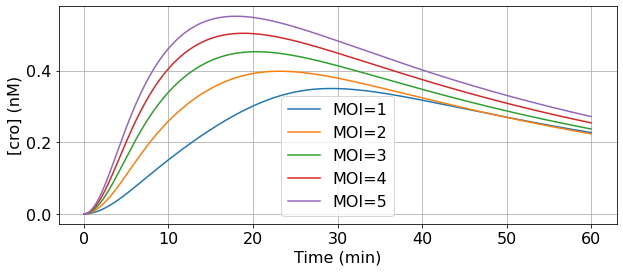

In [330]:
klamb = 0.131;
kd = 1/50; 
plt.rcParams["figure.figsize"] = (10,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    plt.plot(t,sol0[:,4]/610,label='MOI='+str(moi))
    plt.legend(ncol=1)
#plt.axhline(1,color='black')
plt.xlabel('Time (min)')
plt.ylabel('[cro] (nM)')
plt.grid()

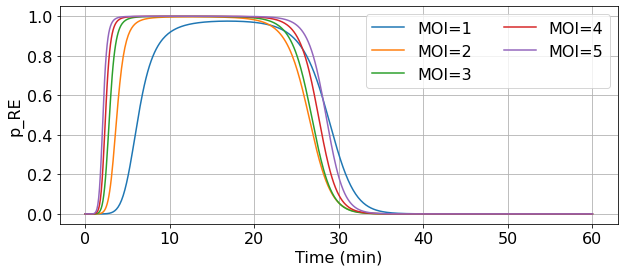

In [320]:
f_cI_RE(cII)
klamb = 0.131;
kd = 1/50; 
plt.rcParams["figure.figsize"] = (10,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    cII = sol0[:,5];
    pRE = f_cI_RE(cII); 
    plt.plot(t,pRE,label='MOI='+str(moi))
    plt.legend(ncol=2)
plt.xlabel('Time (min)')
plt.ylabel('p_RE')
plt.grid()

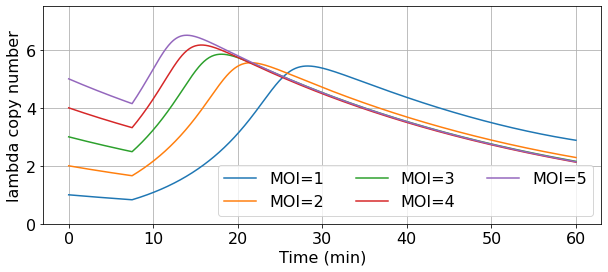

In [329]:
f_cI_RE(cII)
klamb = 0.131;
kd = 1/40; 
plt.rcParams["figure.figsize"] = (10,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    lambda_N = sol0[:,6];
    plt.plot(t,lambda_N/C,label='MOI='+str(moi))
    plt.legend(ncol=3)
plt.xlabel('Time (min)')
plt.ylabel('lambda copy number')
plt.ylim(0,7.5)
plt.grid()

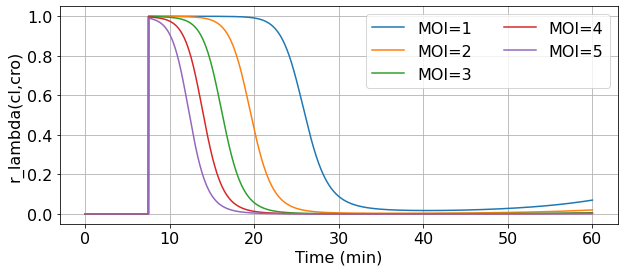

In [353]:
f_cI_RE(cII)
klamb = 0.131;
kd = 1/40; 
t = np.linspace(0, 60, 60*60+1);
plt.rcParams["figure.figsize"] = (10,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    cI = sol0[:,3];
    cro = sol0[:,4];
    r_lambda = np.zeros(len(cI))
    t1 = np.where(t>=tau_lamb)[0][0];
    r_lambda[t1:] = 1/(1+np.power(cI[t1:]/K_lamb_cI,n_lamb_cI)+np.power(cro[t1:]/K_lamb_cro,n_lamb_cro))
    plt.plot(t,r_lambda,label='MOI='+str(moi))
    plt.legend(ncol=2)
plt.xlabel('Time (min)')
plt.ylabel('r_lambda(cI,cro)')
plt.grid()

In [357]:
my_arr = np.zeros((2,len(t)));
my_arr[0,:] = t;
my_arr[1,:] = r_lambda; 
np.savetxt("r_lambda.csv", my_arr, delimiter=",")


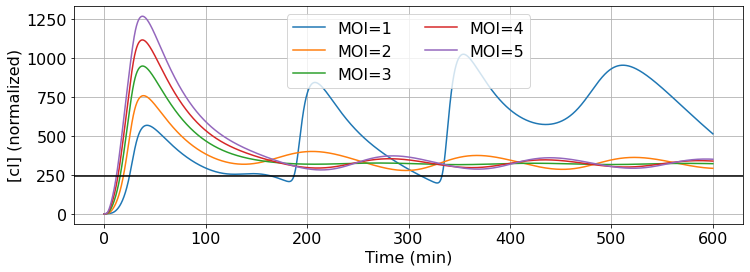

In [338]:
t = np.linspace(0, 600, 6001);
klamb = 0.131;
kd = 1/50; 
plt.rcParams["figure.figsize"] = (12,4)
for moi in np.arange(1,6,1):
    lamb0 = moi*C;
    y0 = [0,0,0,0,0,0,lamb0];
    sol0 = odeint(myfunc1, y0, t);
    plt.plot(t,sol0[:,3],label='MOI='+str(moi))
    plt.legend(ncol=2)
plt.axhline(241,color='black')
plt.xlabel('Time (min)')
plt.ylabel('[cI] (normalized)')
plt.grid()